### Outlook
* Stochastic Depth 
* Warm up 
* Label Smoothing 
* No Bias Weight Decay 
* Teacher-Student Knowledge Distillation 
* Mixup 
* Group Normalization 
* Weight Standardization 

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### Stochastic Depth

In [68]:
class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """

    def basic_forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out = self.se_module(out) + residual
        out = self.relu(out)
        return out

    def forward(self, x):
        if self.stochastic_depth and self.training:
            run = torch.bernoulli(self.probability)
        else:
            run = 1
            
        if run:
            x = self.basic_forward(X)

            
        return x
            
        

            
            
class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0)


        self.fc2 = nn.Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0
        )

        self.relu = nn.LeakyReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x
    

class SEBottleneck(Bottleneck):

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        groups,
        reduction,
        stride=1,
        downsample=None,
        stochastic_depth=True,
        probability=1,
    ):
        super().__init__()
        self.stochastic_depth = stochastic_depth
        if not isinstance(probability, torch.Tensor):
            probability = torch.tensor(probability)
        self.probability = probability
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(
            planes * 2,
            planes * 4,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=groups,
            bias=False,
        )
        self.conv3 = nn.Conv2d(planes * 4, planes, kernel_size=1, bias=False)


        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.bn3 = nn.BatchNorm2d(planes)

        self.relu = nn.LeakyReLU(inplace=True)
        self.se_module = SEModule(
            planes,
            reduction=reduction,)
        self.downsample = downsample
        self.stride = stride


In [69]:
model = SEBottleneck(32, 32, 1, 4, probability=0.8).train()

In [79]:
input_features = torch.randn(4, 32, 32, 32)
ouptut = model(input_features)

skip


In [82]:
# bernoulli
value = 0
count = 100000
for _ in range(count):
    value += torch.bernoulli(torch.tensor(0.8))
print((value / count).item())

0.8002899885177612


---

#### Warm up 

In [111]:
import math

from torch.optim import Optimizer

## modify from source : https://github.com/Tony-Y/pytorch_warmup#radam-warmup


class BaseWarmup:
    """Base class for all warmup schedules
    Arguments:
        optimizer (Optimizer): an instance of a subclass of Optimizer
        warmup_params (list): warmup paramters
        last_step (int): The index of last step. (Default: -1)
    """

    def __init__(self, optimizer: Optimizer, warmup_params, last_step=-1):
        self.optimizer = optimizer
        self.warmup_params = warmup_params
        self.last_step = last_step
        self.step()

    def state_dict(self):
        """Returns the state of the warmup scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {
            key: value for key, value in self.__dict__.items() if key != "optimizer"
        }

    def load_state_dict(self, state_dict):
        """Loads the warmup scheduler's state.
        Arguments:
            state_dict (dict): warmup scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def step(self, step=None):
        """Dampen the learning rates.
        Arguments:
            step (int): The index of current step. (Default: None)
        """
        if step is None:
            step = self.last_step + 1
        self.last_step = step

        for group, params in zip(self.optimizer.param_groups, self.warmup_params):
            omega = self.warmup_factor(step, **params)
            group["lr"] *= omega

    def warmup_factor(self, step, **params):
        raise NotImplementedError


class ExponentialWarmup(BaseWarmup):
    """Exponential warmup schedule.
    Arguments:
        optimizer (Optimizer): an instance of a subclass of Optimizer
        warmup_period (int or list): Effective warmup period
        last_step (int): The index of last step. (Default: -1)
    """

    def __init__(self, optimizer, warmup_period, last_step=-1):
        group_count = len(optimizer.param_groups)
        warmup_params = [dict(warmup_period=warmup_period) for _ in range(group_count)]
        super().__init__(optimizer, warmup_params, last_step)

    def warmup_factor(self, step, warmup_period):
        # min(1.0, (step+1) / warmup_period)
        return 1.0 - math.exp(-(step + 1) / warmup_period)

In [112]:
from torchvision import models
from torch import optim
model = models.resnet18()

In [113]:
num_steps = 1000
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
warmup_scheduler = ExponentialWarmup(optimizer, warmup_period=num_steps // 10)

In [114]:
lr_ = []
for _ in range(num_steps):
    lr_scheduler.step(lr_scheduler.last_epoch + 1)
    warmup_scheduler.step()
    lr_.append(optimizer.param_groups[0]["lr"])

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

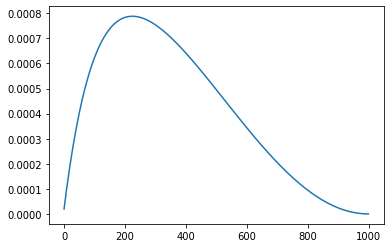

In [116]:
plt.plot(lr_)
plt.show()

---

#### Label smoothing

In [121]:
from typing import Union
import numpy as np

class LabelSmoothing(nn.Module):
    def __init__(self, classes: int, smoothing: float = 0.1):
        super().__init__()
        assert 0 <= smoothing < 1
        if not smoothing:
            self.criterion_entropy = nn.CrossEntropyLoss()
            print("Deactivated smoothing, apply CrossEntropyLoss.")
        else:
            #batchmean
            self.criterion = nn.KLDivLoss(reduction="batchmean")
            print("Activated smoothing, apply KLDivLoss.")

        self.classes = classes
        self.smoothing = smoothing
        self.confidence = 1 - smoothing

    @torch.no_grad()
    def convert_label_to_smooth(self, true_labels: torch.Tensor):
        label_shape = torch.Size((true_labels.size(0), self.classes))
        true_dist = torch.empty(size=label_shape, device=true_labels.device)
        true_dist.fill_(self.smoothing / (self.classes - 1))
        true_dist = true_dist.scatter_(1, true_labels.data, self.confidence)
        return true_dist

    def forward(
        self, prediction: torch.Tensor, true_labels: Union[np.ndarray, torch.Tensor]
    ):
        """
        prediction  -> shape == [batch, self.classes]
        true_labels -> shape == [batch, 1]
        """
        if prediction.shape[1] != self.classes:
            raise ValueError(
                f"Mismatch between prediction and specified class number, have pre-specified classes equal to {self.classes} while {prediction.shape[1]} in prediction"
            )
        if not isinstance(true_labels, torch.Tensor):
            true_labels = torch.tensor(true_labels, dtype=torch.long)
        else:
            true_labels = true_labels.type(torch.long)
        if self.smoothing:
            print(true_labels)
            print("----------")
            true_labels = self.convert_label_to_smooth(true_labels.reshape(-1, 1))
            print("convert to smooth")
            print("----------")
            print(true_labels)
            prediction = prediction.log_softmax(-1)
            loss = self.criterion(prediction, true_labels)
        else:
            loss = self.criterion_entropy(prediction, true_labels.reshape(-1))
        return loss

In [122]:
model = LabelSmoothing(5)

Activated smoothing, apply KLDivLoss.


In [123]:
prediction = torch.randn(4, 5)
label = torch.tensor([0, 4, 3, 1]).reshape(4, 1)

In [124]:
loss = model(prediction, label)

tensor([[0],
        [4],
        [3],
        [1]])
----------
convert to smooth
----------
tensor([[0.9000, 0.0250, 0.0250, 0.0250, 0.0250],
        [0.0250, 0.0250, 0.0250, 0.0250, 0.9000],
        [0.0250, 0.0250, 0.0250, 0.9000, 0.0250],
        [0.0250, 0.9000, 0.0250, 0.0250, 0.0250]])


In [150]:
ground_truth = torch.tensor([5], dtype=torch.long)
raw_prediction = torch.tensor([0.4, 0.8, 20, 1, 2, 3], dtype=torch.float32).reshape(1, -1)

In [151]:
raw_prediction.shape

torch.Size([1, 6])

In [152]:
import torch
import torch.nn as nn
ground_truth = torch.tensor([5], dtype=torch.long)
raw_prediction = torch.tensor([0.4, 0.8, 20, 1, 2, 3], dtype=torch.float32).reshape(1, -1)

criterion = nn.CrossEntropyLoss()
loss = criterion(raw_prediction, ground_truth)
print(f"CrossEntropy : {loss}")

ground_truth = torch.tensor([0, 0, 0, 0, 0, 1], dtype=torch.float)
raw_prediction = torch.tensor([0.4, 0.8, 20, 1, 2, 3], dtype=torch.float32).reshape(1, -1)
prediction_log_softmax = F.log_softmax(raw_prediction, dim=-1)
criterion = nn.KLDivLoss(reduction='batchmean')
loss = criterion(prediction_log_softmax, ground_truth)
print(f"KLDivLoss : {loss}")

CrossEntropy : 17.0
KLDivLoss : 17.0


---

#### No Bias Weight Decay

In [154]:
def add_weight_decay(net, l2_value, skip_list=[]):
    decay, conv_decay, no_decay =[], [], []
    for name, param in net.named_parameters():
        if not param.requires_grad:
            continue  # skip frozen weights
        # skip bias and bn layer
        if name.endswith(".bias") or ("_bn" in name) or (name in skip_list):
            no_decay.append(param)
        elif ("conv" in name):
            conv_decay.append(param)
        else:
            decay.append(param)
    return [
        {"params": no_decay, "weight_decay": 0.0},
        {"params": conv_decay, "weight_decay": l2_value * 2},
        {"params": decay, "weight_decay": l2_value},
    ]

In [155]:
model = models.resnet18()
parameters = add_weight_decay(model, 0.00001)

In [156]:
optimizer = optim.Adam(parameters, lr=0.001, betas=(0.9, 0.999),)


In [160]:
optimizer = optim.Adam(parameters, lr=0.001, betas=(0.9, 0.999),)

In [157]:
parameters[0]["weight_decay"]

0.0

In [158]:
parameters[1]["weight_decay"]

2e-05

In [159]:
parameters[2]["weight_decay"]

1e-05

---

#### Mixup

In [161]:
from torch.distributions.beta import Beta


class Mixup(nn.Module):
    def __init__(self, alpha: float = 0.2):
        super().__init__()
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()
        self.beta = Beta(alpha, alpha)

    def __get_mixup_batch(
        self, mini_batch_image: torch.Tensor, mini_batch_label: torch.Tensor
    ):
        lambda_ = self.beta.sample()
        batch_size = mini_batch_image.shape[0]
        shuffle = torch.randperm(batch_size)
        shuffle_mini_batch_x = mini_batch_image[shuffle]
        shuffle_mini_batch_y = mini_batch_label[shuffle]
        mixup_x = lambda_ * mini_batch_image + (1 - lambda_) * shuffle_mini_batch_x
        return (
            mixup_x,
            mini_batch_label.reshape(-1),
            shuffle_mini_batch_y.reshape(-1),
            lambda_,
        )

    def forward(
        self,
        model: nn.Module,
        mini_batch_image: torch.Tensor,
        mini_batch_label: torch.Tensor,
    ):
        """
        mini_batch_image -> shape == [batch, channel, height, width]
        mini_batch_label -> shape == [batch, 1] or [batch]
        """
        (
            mixup_x,
            mini_batch_label,
            shuffle_mini_batch_y,
            lambda_,
        ) = self.__get_mixup_batch(mini_batch_image, mini_batch_label)
        output = model(mixup_x)
        loss = self.criterion(output, mini_batch_label) * lambda_ + (
            1 - lambda_
        ) * self.criterion(output, shuffle_mini_batch_y)
        return mixup_x, loss

In [162]:
trainer = Mixup()
model = models.resnet18()

In [163]:
mini_batch_image = torch.cat((torch.ones(3, 3, 64, 64) , torch.zeros(3, 3, 64, 64)), 0)
mini_batch_label = torch.tensor([1, 1, 1, 0, 0, 0])

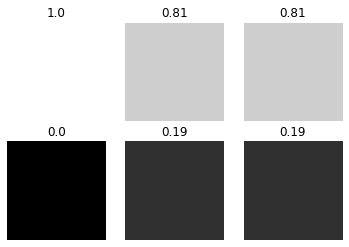

In [212]:
image_, loss = trainer(model, mini_batch_image, mini_batch_label)
for _ in range(6):
    plt.subplot(231+_)
    plt.title(round((image_[_].mean()).item(), 2))
    plt.axis('off')
    plt.imshow(image_[_].permute(1, 2, 0))
plt.show()

---

#### Teacher-Student Knowledge Distillation

In [164]:
from typing import Union

import torch
import torch.nn as nn


class DistillationLoss(nn.Module):
    def __init__(self, temperature: Union[int, float] = 2):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction="batchmean")
        self.temperature = temperature
        self.softmax = nn.Softmax(1)
        self.logsoftmax = nn.LogSoftmax(1)

    def forward(self, student_output: torch.Tensor, teacher_output: torch.Tensor, label):
        """
        student_output -> shape == [batch, class_number]
        teacher_output -> shape == [batch, class_number]
        """

        if student_output.shape != teacher_output.shape:
            raise ValueError(
                f"Mismatch between student_output and teacher_output, got student_output : {student_output.shape} & teacher_output : {teacher_output.shape} respectively"
            )
        student_output = self.logsoftmax(student_output / self.temperature)
        teacher_output = self.softmax(teacher_output / self.temperature)
        
        hard_loss = self.Cross(student_output, label)

        soft_loss = (
            self.criterion(student_output, teacher_output)
            * self.temperature
            * self.temperature
        )
        loss = hard_loss * 0.8 + soft_loss * 0.2
        return loss

In [165]:
distill = DistillationLoss()

In [166]:
student_output = torch.randn(32, 4)
teacher_output = torch.randn(32, 4)
loss = distill(student_output, teacher_output)

---

#### Weight Standardization 

In [25]:
class Conv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [26]:
model = Conv2d(12, 12, 3)
output = model(torch.randn(1, 12 ,32, 32))

---

![](assets/GN.png)

#### Group Normalization

In [168]:
dummy_input = torch.randn(16, 10, 32, 32) # batch, channel, height, width (2, 1)

In [ ]:
input_ = (16, 3, 32, 32) 2 ** 3

In [ ]:
cnn_output = (16, 512 * 4, 4) , (16 b, 512 c, 4 time_step), (4, 16, 512) 

#### BN

In [169]:
average_ = dummy_input.mean([0, 2, 3], keepdim=True)
std_ = dummy_input.std([0, 2, 3], keepdim=True)
normalization = (dummy_input - average_) / std_

#### GN

In [171]:
## 當N group == 1 時, GN == LN, 當 group == C 時, GN == IN
n_group = 10
dummy_input_copy = dummy_input.clone()
b, c, h, w = dummy_input_copy.size()
dummy_input_copy = dummy_input_copy.reshape(b, n_group, int(c / n_group), h, w)
average_ = dummy_input_copy.mean([2, 3, 4], keepdim=True)
std_ = dummy_input_copy.std([2, 3, 4], keepdim=True)
normalization = (dummy_input_copy - average_) / std_
normalization = normalization.reshape(b, c, h, w)